In [1]:
""" 
    equation
"""

' \n    equation\n'

In [2]:
from dolfin import *
from mshr import *
import matplotlib.pyplot as plt
import numpy as np
import random

In [3]:
# =========================================
# function bank

def strain(v):
    return grad(v)[0]

class LoadStepper:

    """
    Time "integrator" for a problem with no time derivatives.  This 
    is basically just to keep track of a parameter, ``self.t``, that
    can be used to parameterize external loading.
    """

    def __init__(self,DELTA_T,t=0.0):
        """
        Initializes the ``LoadStepper`` with a (pseudo)time step ``DELTA_T``
        and initial time ``t``, which defaults to zero.
        """
        self.DELTA_T = DELTA_T
        self.tval = t
        self.t = Expression("t",t=self.tval,degree=0)
        self.advance()

    def advance(self):
        """
        Increments the loading.
        """
        self.tval += float(self.DELTA_T)
        self.t.t = self.tval

In [4]:
# ==========================================
# parameters

# ------------------------------------------
# mesh
xmin = 0.0
xmax = 1.0
nel = 10000
p_order = 2

# ------------------------------------------
# material system (nondimensional)
d_NonDim = 0.5 # d/H
wl_NonDim = 0.1  # lambda/H
fe_NonDim = 0.005  # lambda*tao/k

d_NonDim = 0.15 # d/H
wl_NonDim = 0.02  # lambda/H
fe_NonDim = 0.001  # lambda*tao/k

In [5]:
# ------------------------------------------
# time stepping
N_STEPS = 10
DELTA_T = 1.0/float(N_STEPS)
stepper = LoadStepper(DELTA_T)

In [6]:
# test
print(stepper.t)

f_0


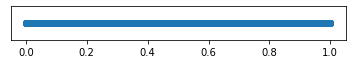

In [7]:
# ==========================================
# mesh
mesh = IntervalMesh(nel, xmin, xmax)

plot(mesh)

# ------------------------------------------
# define BCs
class Left(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], xmin, 1.e-14) and on_boundary
class Right(SubDomain):
    def inside(self, x, on_boundary):
        return near(x[0], xmax, 1.e-14) and on_boundary

# This imposes a Dirichlet condition at the point x=0
def Dirichlet_x0_boundary(x,on_boundary):
    tol = 1e-14
    return abs(x[0]-xmin)<tol
# This imposes a Dirichlet condition at the point x=1
def Dirichlet_x1_boundary(x,on_boundary):
    tol = 1e-14
    return abs(x[0]-xmax)<tol

In [8]:
# =========================================
# function space

V1D = FiniteElement('CG',mesh.ufl_cell(),p_order)
# u1 and u2 for the bot and top layers
V   = FunctionSpace(mesh,V1D)

In [9]:
# =========================================
# Disp. bc
# Enforce u1=0,u2=0 at x=0
#         u1=d      at x=1
# ---------------------------------------
u_A = Constant(d_NonDim/N_STEPS)
bcs = [DirichletBC(V, Constant(0),        Dirichlet_x0_boundary),
       DirichletBC(V, u_A,      Dirichlet_x1_boundary)]

In [10]:
# weak form
# ---------------------------------------
u1_0 = Function(V)
u1   = Function(V)
# initialize u1_0
# 


# Define variational problem
ddu1 = TestFunction(V)
du1 = Function(V)

# current step
# u1 = (u1_0+du1)

# weak form
F = inner(strain((u1_0+du1)),strain(ddu1))*dx + \
    1/d_NonDim*fe_NonDim/wl_NonDim*sin(2*pi/wl_NonDim*d_NonDim*(u1_0+du1))*ddu1*dx

J = derivative(F, du1)
problem = NonlinearVariationalProblem(F, du1, bcs, J)
solver  = NonlinearVariationalSolver(problem)
# solver = NewtonSolver()

------- Step: 0 , t = 0.1 -------
------- Step: 1 , t = 0.2 -------
------- Step: 2 , t = 0.30000000000000004 -------
------- Step: 3 , t = 0.4 -------
------- Step: 4 , t = 0.5 -------
------- Step: 5 , t = 0.6 -------
------- Step: 6 , t = 0.7 -------
------- Step: 7 , t = 0.7999999999999999 -------
------- Step: 8 , t = 0.8999999999999999 -------
------- Step: 9 , t = 0.9999999999999999 -------


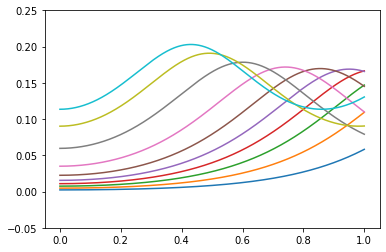

In [11]:
# plt.figure()
# plt.xlim(0.0-0.05, 1.0+0.05)
# plt.ylim(0.0-0.05, d_NonDim+0.05)

for i in range(N_STEPS):
    print("------- Step: "+str(i)+" , t = "+str(stepper.tval)+" -------")
    solver.solve()
    u1_0.vector()[:] = u1_0.vector()+du1.vector()
    
#     plt.figure()
# #     plot(du1)
#     plot(u1_0)
#     plt.xlim(0.0-0.05, 1.0+0.05)
#     plt.ylim(0.0-0.05, d_NonDim+0.05)
    plot(strain(u1_0))
    plt.xlim(0.0-0.05, 1.0+0.05)
    plt.ylim(0.0-0.05,d_NonDim+0.10)
    # advance to the next load step
    stepper.advance()